<a href="https://colab.research.google.com/github/haedongmu/AIFFEL_quest_cr/blob/main/Project/Dataton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#구글드라이브 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터셋 읽기
import pandas as pd
file_name_list = ['netflix_titles', 'disney_plus_titles', 'amazon_prime_titles']
root_path = '/content/drive/My Drive/아이펠/'
file_ext = 'csv'
# 여러 파일을 읽어서 하나의 데이터프레임으로 합치기
dataframes = []  # 데이터를 저장할 리스트

for file_name in file_name_list:
    file_path = f"{root_path}{file_name}.{file_ext}"  # 경로 생성
    df = pd.read_csv(file_path)  # CSV 파일 읽기

    # 파일명을 가공해 새로운 필드 추가
    platform_name = file_name.split('_titles')[0]  # '_titles' 앞부분 추출
    df['platform'] = platform_name  # 새로운 열 추가

    # 필요한 열만 선택하고 순서 정렬
    df = df[['platform', 'title', 'listed_in', 'description']]

    dataframes.append(df)  # 리스트에 추가

# 데이터프레임 결합
combined_data = pd.concat(dataframes, ignore_index=True)

# 결과 확인
from tabulate import tabulate
print(tabulate(combined_data.head(), headers='keys', tablefmt='grid'))



+----+------------+-----------------------+---------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | platform   | title                 | listed_in                                                     | description                                                                                                                                              |
+====+============+=======================+===============================================================+==========================================================================================================================================================+
|  0 | netflix    | Dick Johnson Is Dead  | Documentaries                                                 | As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and co

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

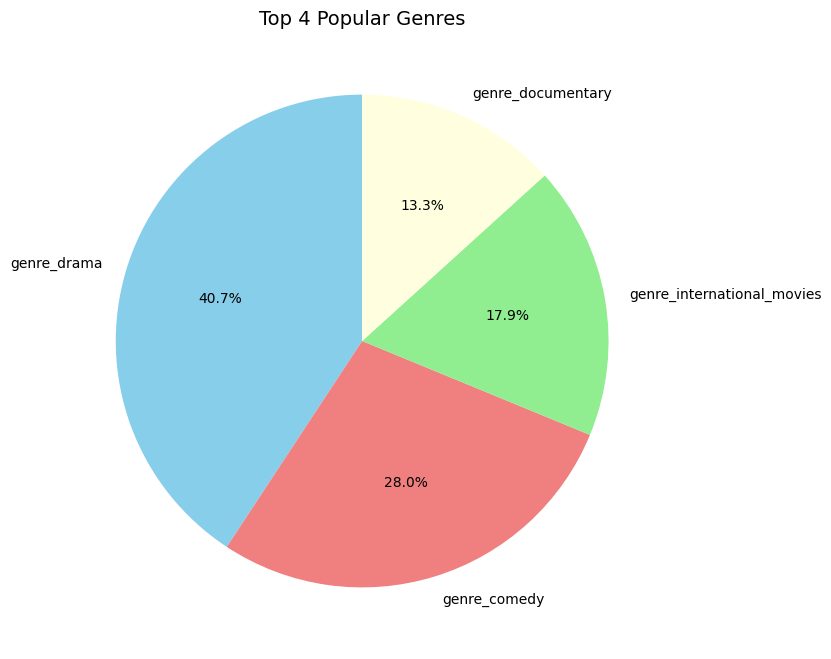

In [ ]:
import difflib
from nltk.stem import WordNetLemmatizer

# WordNetLemmatizer 초기화
lemmatizer = WordNetLemmatizer()

# 유사한 장르를 그룹화하는 함수
def group_similar_genres(genres, threshold=0.8):
    unique_genres = list(set(genres))  # 고유한 장르 목록
    grouped_genres = {}

    for genre in unique_genres:
        # 복수형을 단수형으로 변환
        genre_singular = lemmatizer.lemmatize(genre.lower())
        matched = False
        for key in grouped_genres:
            # 유사도 계산 (difflib)
            similarity = difflib.SequenceMatcher(None, genre_singular, key.lower()).ratio()
            if similarity >= threshold:
                grouped_genres[key].append(genre)
                matched = True
                break
        if not matched:
            grouped_genres[genre_singular] = [genre]

    # 그룹화된 결과 반환
    return grouped_genres

# 장르 목록을 combined_data에서 가져오는 예시 (combined_data['genres']에 장르 목록이 있다고 가정)
all_genres = [genre for genres in combined_data['genres'] for genre in genres]

# 유사한 장르명 그룹화
grouped_genres = group_similar_genres(all_genres, threshold=0.8)

# 원핫 인코딩 열을 만들 때, 그룹화된 장르명에 대해 원핫 인코딩을 적용
def generate_one_hot_encoding(df, grouped_genres):
    # 고유한 장르 그룹을 가져옴
    unique_genre_groups = list(grouped_genres.keys())

    # 원핫 인코딩 열 생성
    for genre_group in unique_genre_groups:
        df[f'genre_{genre_group.replace(" ", "_")}'] = df['genres'].apply(
            lambda x: 1 if any(g in grouped_genres[genre_group] for g in x) else 0
        )

    return df

# 원본 데이터프레임에서 원핫 인코딩 적용
combined_data_with_one_hot = generate_one_hot_encoding(combined_data.copy(), grouped_genres)

# 장르별 등장 횟수를 계산 (원핫 인코딩된 열만 사용)
genre_counts = combined_data_with_one_hot[[
    f'genre_{group.replace(" ", "_")}' for group in grouped_genres.keys()
]].sum()

# 장르별 등장 횟수를 내림차순으로 정렬하고, 상위 4개 장르를 추출합니다.
top_4_genres = genre_counts.sort_values(ascending=False).head(4)

#가장 인기있는 장르 1~4위 추출
# 장르별 등장 횟수를 계산 (원핫 인코딩된 열만 사용)
genre_counts = combined_data_with_one_hot[[
    f'genre_{group.replace(" ", "_")}' for group in grouped_genres.keys()
]].sum()

# 장르별 등장 횟수를 내림차순으로 정렬하고, 상위 4개 장르를 추출합니다.
top_4_genres = genre_counts.sort_values(ascending=False).head(4)

# 원형 차트로 시각화
plt.figure(figsize=(8, 8))
top_4_genres.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'], legend=False)
plt.title('Top 4 Popular Genres', fontsize=14)
plt.ylabel('')  # ylabel 제거
plt.show()

In [ ]:
import difflib
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# WordNetLemmatizer 초기화
lemmatizer = WordNetLemmatizer()

# 장르별 등장 횟수를 계산 (원핫 인코딩된 열만 사용)
genre_counts = combined_data_with_one_hot[[
    f'genre_{group.replace(" ", "_")}' for group in grouped_genres.keys()
]].sum()

# 상위 4개 장르 (원핫 인코딩된 컬럼 값이 1인 것만 필터링하여 추출)
top_4_genres = genre_counts[genre_counts > 0].sort_values(ascending=False).head(4).index.tolist()

# 원핫 인코딩된 장르 필드 이름에서 실제 장르 이름으로 변환
def get_genre_name(genre_field):
    return genre_field.replace('genre_', '').replace('_', ' ').title()

# top_4_genres를 기반으로 keywords_by_genre 동적으로 생성
keywords_by_genre = {get_genre_name(genre): {} for genre in top_4_genres}

# 단어 추출 함수 (description에서 키워드 추출)
def extract_keywords(description, top_n=10):
    if pd.notnull(description) and isinstance(description, str) and len(description.strip()) > 0:
        vectorizer = CountVectorizer(stop_words='english', max_features=top_n)
        try:
            X = vectorizer.fit_transform([description])
            feature_names = vectorizer.get_feature_names_out()

            # 단어 빈도 출력
            word_freq = dict(zip(feature_names, X.toarray().flatten()))
            return word_freq
        except ValueError:
            # 만약 CountVectorizer가 단어를 추출할 수 없으면 빈 딕셔너리 반환
            return {}
    return {}

# 각 행을 읽어 장르를 확인하고 해당 장르에 키워드를 등록
for _, row in combined_data_with_one_hot.iterrows():
    # 각 행에 대해 원핫 인코딩된 장르 필드에서 값이 1인 장르 추출
    for genre_field in top_4_genres:
        if row[genre_field] == 1:  # 해당 장르가 1인 경우
            genre_name = get_genre_name(genre_field)  # 장르 이름 추출
            description = combined_data.loc[row.name, 'description']  # 해당 행의 description
            keywords = extract_keywords(description)  # 키워드 추출

            # 키워드를 해당 장르의 딕셔너리에 등록
            for keyword, count in keywords.items():
                if keyword in keywords_by_genre[genre_name]:
                    keywords_by_genre[genre_name][keyword] += count
                else:
                    keywords_by_genre[genre_name][keyword] = count

# 결과 출력 (각 장르별로 키워드 빈도)
for genre, keyword_freq in keywords_by_genre.items():
    print(f"\nTop Keywords for {genre}:")
    sorted_keywords = sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True)
    for keyword, freq in sorted_keywords[:10]:
        print(f"{keyword}: {freq}")



Top Keywords for Drama:
life: 716
love: 591
man: 482
story: 471
family: 441
new: 441
father: 304
old: 271
mother: 245
lives: 219

Top Keywords for Comedy:
life: 407
new: 361
love: 330
man: 290
family: 267
friends: 212
comedy: 191
old: 168
school: 148
father: 143

Top Keywords for International Movies:
man: 283
life: 246
family: 222
love: 210
father: 143
new: 143
finds: 115
documentary: 110
friends: 108
home: 102

Top Keywords for Documentary:
documentary: 331
life: 193
story: 139
new: 129
film: 103
series: 101
world: 101
look: 85
history: 82
family: 72


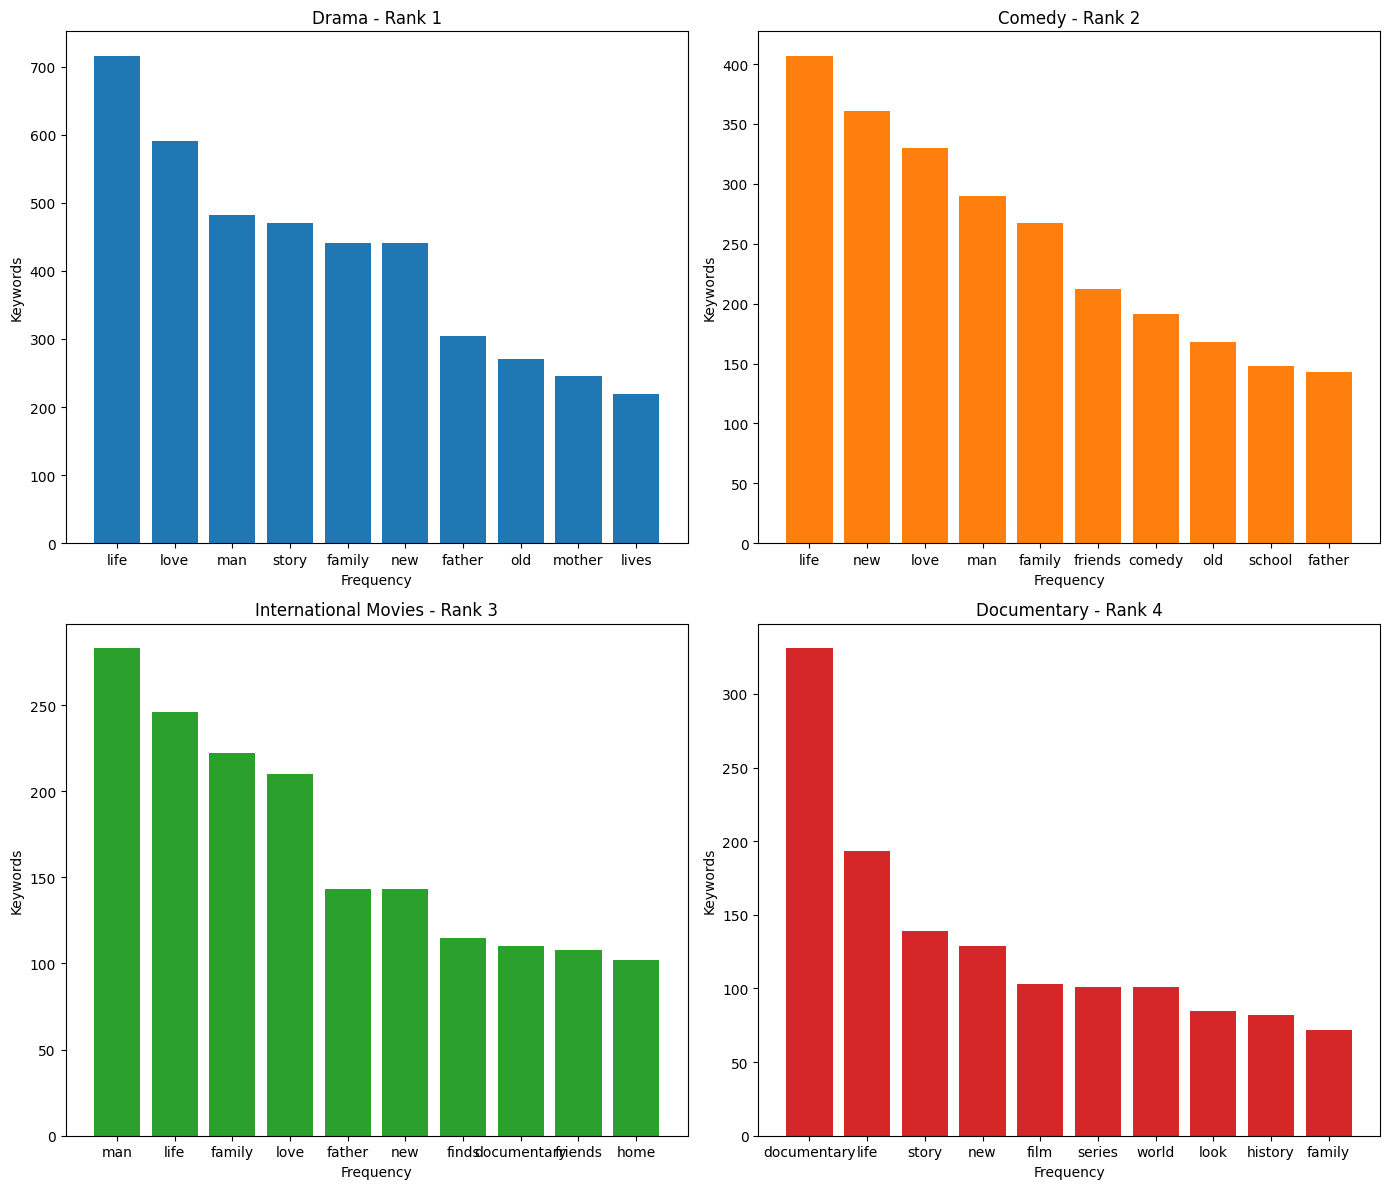

In [ ]:
import matplotlib.pyplot as plt

# 각 장르별 키워드 빈도 그래프 생성
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 색상 리스트를 지정 (4개의 다른 색상)
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 파란색, 주황색, 초록색, 빨간색

# 2x2로 나누어 각 장르의 키워드 빈도 차트를 그리기
for i, (genre, keyword_freq) in enumerate(keywords_by_genre.items()):
    # 키워드 빈도를 내림차순으로 정렬하고 상위 10개 추출
    sorted_keywords = sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True)[:10]

    # 키워드와 빈도 추출
    keywords, frequencies = zip(*sorted_keywords)

    ax = axes[i // 2, i % 2]  # 2x2 배열의 각 축에 접근
    ax.bar(keywords, frequencies, color=color_list[i])  # 색상 리스트에서 해당 장르에 색상 적용
    ax.set_ylabel('Keywords')
    ax.set_xlabel('Frequency')
    ax.set_title(f'{genre} - Rank {i+1}')  # 제목에 장르 순위 추가

# 레이아웃 조정
plt.tight_layout()
plt.show()


